In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def f1_from_nonzero(A_true, A_est):
    A_true_nz = (A_true != 0)
    A_est_nz  = (A_est  != 0)

    TP = np.sum(A_true_nz & A_est_nz)
    FP = np.sum(~A_true_nz & A_est_nz)
    FN = np.sum(A_true_nz & ~A_est_nz)

    precision = TP / (TP + FP + 1e-12)
    recall    = TP / (TP + FN + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)

    return TP, FP, FN, precision, recall, f1

In [20]:
folder = "result_d4_s3(new_reg)"  

W1_thres = 0.3
W2_thres = 0.2

# Track best files
best_f1_W1 = -1.0
best_f1_W1_file = None

best_f1_W2 = -1.0
best_f1_W2_file = None

best_avg_f1 = -1.0
best_avg_f1_file = None

for filename in os.listdir(folder):

    file_path = os.path.join(folder, filename)
    print("Processing:", file_path)

    with open(file_path, "r") as f:
        data = json.load(f)

    # --- truth ---
    W_truth = np.array(data["W_truth"])
    Sigma_truth = np.array(data["Sigma_truth"])  # assumes this key exists

    W_truth[np.abs(W_truth) < W1_thres] = 0
    Sigma_truth[np.abs(Sigma_truth) < W2_thres] = 0

    # --- pick run_id == 0 ---
    W_est = None
    Sigma_est = None
    chosen_run = None

    for run in data["random_runs"]:
        if run["run_id"] == 0:
            chosen_run = run
            W_est = np.array(run["W_est_random"])
            Sigma_est = np.array(run["Sigma_est_random"])
            break

    if W_est is None or Sigma_est is None:
        print(f"  Skipping {filename}: run_id == 0 not found.")
        continue

    # --- threshold estimates ---
    W_est[np.abs(W_est) < W1_thres] = 0
    Sigma_est[np.abs(Sigma_est) < W2_thres] = 0

    # --- F1 for W ---
    TP_W1, FP_W1, FN_W1, precision_W1, recall_W1, f1_W1 = f1_from_nonzero(W_truth, W_est)

    # --- F1 for Sigma (strictly lower-triangular) ---
    TP_W2, FP_W2, FN_W2, precision_W2, recall_W2, f1_W2 = f1_from_nonzero(
        np.tril(Sigma_truth, k=-1),
        np.tril(Sigma_est,   k=-1),
    )

    # --- save metrics into JSON ---
    data["f1_W1"] = round(f1_W1, 4)
    data["f1_W2"] = round(f1_W2, 4)
    # print("TP_W1", TP_W1)
    data["TP_W1"] = TP_W1.item()
    data["FP_W1"] = FP_W1.item()
    data["FN_W1"] = FN_W1.item()

    data["TP_W2"] = TP_W2.item()
    data["FP_W2"] = FP_W2.item()
    data["FN_W2"] = FN_W2.item()

    with open(file_path, "w") as f:
        json.dump(data, f, indent=2)

    # --- update best trackers ---
    avg_f1 = 0.5 * (f1_W1 + f1_W2)

    if f1_W1 > best_f1_W1:
        best_f1_W1 = f1_W1
        best_f1_W1_file = filename

    if f1_W2 > best_f1_W2:
        best_f1_W2 = f1_W2
        best_f1_W2_file = filename

    if avg_f1 > best_avg_f1:
        best_avg_f1 = avg_f1
        best_avg_f1_file = filename

# After the loop, print results
print("\n=== Best files ===")
print(f"Best f1_W1: {best_f1_W1:.4f} in file {best_f1_W1_file}")
print(f"Best f1_W2: {best_f1_W2:.4f} in file {best_f1_W2_file}")
print(f"Best average (f1_W1 + f1_W2)/2: {best_avg_f1:.4f} in file {best_avg_f1_file}")

Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.1_lambda_corr0.01_lambda_nl1.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.01_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.1_lambda_corr0.01_lambda_nl12.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.1_lambda_corr0.1_lambda_nl12.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.1_lambda_corr0.01_lambda_nl4.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.01_lambda_corr0.1_lambda_nl4.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.01_lambda_corr0.01_lambda_nl12.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.01_lambda_corr0.001_lambda_nl1.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_s3(new_reg)/result_d4_admg3_seed3_lambda0.001_lambda_corr0.1_lambda_nl1.

In [16]:
folder = "result_d4_s4(new_reg)"  
scores = []

for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    print("Processing:", file_path)
    with open(file_path, "r") as f:
        data = json.load(f)
        f1_W1 = data["f1_W1"]
        f1_W2 = data["f1_W2"]
        avg_f1 = 0.5 * (f1_W1 + f1_W2)

    scores.append((filename, f1_W1, f1_W2, avg_f1))

best_f1_W1 = max(s[1] for s in scores)
best_f1_W2 = max(s[2] for s in scores)
best_avg_f1 = max(s[3] for s in scores)

best_f1_W1_files = [f for f, s1, _, _ in scores if s1 == best_f1_W1]
best_f1_W2_files = [f for f, _, s2, _ in scores if s2 == best_f1_W2]
best_avg_f1_files = [f for f, _, _, a in scores if a == best_avg_f1]




Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.01_lambda_corr0.1_lambda_nl12.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.001_lambda_corr0.1_lambda_nl4.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl8.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.01_lambda_corr0.001_lambda_nl8.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl1.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl1.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.001_lambda_corr0.001_lambda_nl8.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.01_lambda_corr0.01_lambda_nl12.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.001_lambda_corr0.001_lambda_nl4.0.json
Processing: result_d4_s4(new_reg)/result_d4_admg4_seed13_lambda0.1_lambda_corr

In [17]:
print(f"Best f1_W1: {best_f1_W1:.4f} in files:\n" +
      "\n".join(best_f1_W1_files))

Best f1_W1: 0.8000 in files:
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl8.0.json


In [18]:
print(f"Best f1_W2: {best_f1_W2:.4f} in files:\n" +
      "\n".join(best_f1_W2_files))

Best f1_W2: 0.6667 in files:
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl8.0.json


In [19]:
print(f"Best avg_f1: {best_avg_f1:.4f} in files:\n" +
      "\n".join(best_avg_f1_files))

Best avg_f1: 0.7333 in files:
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl4.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.001_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl8.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl12.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.01_lambda_nl1.0.json
result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl8.0.json


In [23]:
folder = "result_d4_s4(new_reg)"  
filename = f"result_d4_admg4_seed13_lambda0.1_lambda_corr0.1_lambda_nl8.0.json" 
file_path = os.path.join(folder, filename)
with open(file_path, "r") as f:
        data = json.load(f)

for run in data["random_runs"]:
        if run["run_id"] == 0:
                chosen_run = run
                W_est = np.array(run["W_est_random"])
                Sigma_est = np.array(run["Sigma_est_random"])
                break
f1_W1 = data["f1_W1"]
f1_W2 = data["f1_W2"]
print("f1_W1: ", f1_W1)
print("f1_W2: ", f1_W2)
print("W_est: ", W_est)
print("Sigma_est: ", Sigma_est)

f1_W1:  0.8
f1_W2:  0.6667
W_est:  [[9.80039288e-11 6.23664007e-05 2.05851893e-04 1.08608430e-04]
 [6.33598465e-01 3.56612880e-11 3.90264849e-04 2.90933635e+00]
 [1.36246731e-01 6.50532301e-05 1.69359540e-11 1.55951067e+00]
 [7.18581070e-04 8.50695378e-05 1.86068836e-04 2.98457578e-10]]
Sigma_est:  [[ 5.14223049e-01 -8.80462703e-06 -2.40243870e-06  6.25228146e-01]
 [-8.80462703e-06  9.94097613e-01 -2.66511685e-02  3.60250644e-07]
 [-2.40243870e-06 -2.66511685e-02  1.02418292e+00 -2.27895064e-06]
 [ 6.25228146e-01  3.60250644e-07 -2.27895064e-06  1.01952580e+00]]


## Overall f1 

In [5]:
def admg_to_adjacency(admg: dict):
    """
    Convert ADMG dict to directed and bidirected adjacency matrices.

    Returns:
        A_dir   : [d, d] numpy array, A_dir[i, j] = 1 if i -> j
        A_bidir : [d, d] numpy array, A_bidir[i, j] = 1 if i <-> j
    """
    nodes = sorted(int(k) for k in admg.keys())
    d = len(nodes)

    A_dir = np.zeros((d, d), dtype=int)
    A_bidir = np.zeros((d, d), dtype=int)

    for v_str, info in admg.items():
        v = int(v_str)

        # directed edges: u -> v
        for u in info.get("parents", []):
            A_dir[u, v] = 1

        # bidirected edges: u <-> v
        for u in info.get("spouses", []):
            A_bidir[u, v] = 1
            A_bidir[v, u] = 1  # ensure symmetry

    return A_dir, A_bidir

In [11]:
result_dic = {}
folder = {"result_d4_geomean", "result_d4", "result_d4_linear", "result_d4_nonlinear"}  

for f in folder:
    if f == "result_d4_nonlinear":
        W1_thres = 0.5
        W2_thres = 0.5
    else:
        W1_thres = 0.3
        W2_thres = 0.2
    TP_tot_W1 = 0
    FP_tot_W1 = 0
    FN_tot_W1 = 0

    TP_tot_W2 = 0
    FP_tot_W2 = 0
    FN_tot_W2 = 0

    for filename in os.listdir(f):

        file_path = os.path.join(f, filename)
        print("Processing:", file_path)

        with open(file_path, "r") as d:
            data = json.load(d)

        # --- truth ---
        admg = data["admg"]
        W_truth, Sigma_truth = admg_to_adjacency(admg)
        # W_truth = np.array(data["W_truth"])
        # Sigma_truth = np.array(data["Sigma_truth"])  # assumes this key exists

        # W_truth[np.abs(W_truth) < W1_thres] = 0
        # Sigma_truth[np.abs(Sigma_truth) < W2_thres] = 0

        # --- pick run_id == 0 ---
        W_est = None
        Sigma_est = None
        chosen_run = None

        if f == "result_d4_linear":
            W_est = np.array(data["A_dir"])
            Sigma_est = np.array(data["A_bidir"])
        elif f == "result_d4_nonlinear":
            W_est = np.array(data["directed_adj_final"]) 
            Sigma_est = np.array(data["bidirected_adj_final"])
        else:
            for run in data["random_runs"]:
                if run["run_id"] == 0:
                    chosen_run = run
                    W_est = np.array(run["W_est_random"])
                    Sigma_est = np.array(run["Sigma_est_random"])
                    break

        if W_est is None or Sigma_est is None:
            print(f"  Skipping {filename}: run_id == 0 not found.")
            continue

        # --- threshold estimates ---
        W_est[np.abs(W_est) < W1_thres] = 0
        Sigma_est[np.abs(Sigma_est) < W2_thres] = 0

        # --- F1 for W ---
        TP_W1, FP_W1, FN_W1, precision_W1, recall_W1, f1_W1 = f1_from_nonzero(W_truth, W_est)

        # --- F1 for Sigma (strictly lower-triangular) ---
        TP_W2, FP_W2, FN_W2, precision_W2, recall_W2, f1_W2 = f1_from_nonzero(
            np.tril(Sigma_truth, k=-1),
            np.tril(Sigma_est,   k=-1),
        )

        TP_tot_W1 += TP_W1
        FP_tot_W1 += FP_W1
        FN_tot_W1 += FN_W1

        TP_tot_W2 += TP_W2
        FP_tot_W2 += FP_W2
        FN_tot_W2 += FN_W2

    precision_W1 = TP_tot_W1 / (TP_tot_W1 + FP_tot_W1)
    recall_W1    = TP_tot_W1 / (TP_tot_W1 + FN_tot_W1)
    f1_W1        = 2 * precision_W1 * recall_W1 / (precision_W1+ recall_W1)

    precision_W2 = TP_tot_W2 / (TP_tot_W2 + FP_tot_W2)
    recall_W2    = TP_tot_W2 / (TP_tot_W2 + FN_tot_W2)
    f1_W2        = 2 * precision_W2 * recall_W2 / (precision_W2+ recall_W2)
    result_dic[f"{f}_precision_W1"]=precision_W1
    result_dic[f"{f}_recall_W1"]=recall_W1
    result_dic[f"{f}_f1_W1"]=f1_W1

    result_dic[f"{f}_precision_W2"]=precision_W2
    result_dic[f"{f}_recall_W2"]=recall_W2
    result_dic[f"{f}_f1_W2"]=f1_W2

       

Processing: result_d4_geomean/result_d4_admg20_seed4_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg19_seed6_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg13_seed7_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg23_seed9_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg13_seed4_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg19_seed4_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg2_seed1_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg19_seed0_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg2_seed8_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_geomean/result_d4_admg2_seed0_lambda0.001_lambda_corr0.1_lambda_nl8.0.json
Processing: result_d4_g

In [12]:
result_dic

{'result_d4_geomean_precision_W1': np.float64(0.896774193548387),
 'result_d4_geomean_recall_W1': np.float64(0.7315789473684211),
 'result_d4_geomean_f1_W1': np.float64(0.8057971014492753),
 'result_d4_geomean_precision_W2': np.float64(0.8579234972677595),
 'result_d4_geomean_recall_W2': np.float64(0.9235294117647059),
 'result_d4_geomean_f1_W2': np.float64(0.8895184135977336),
 'result_d4_nonlinear_precision_W1': np.float64(0.22564102564102564),
 'result_d4_nonlinear_recall_W1': np.float64(0.22916666666666666),
 'result_d4_nonlinear_f1_W1': np.float64(0.22739018087855295),
 'result_d4_nonlinear_precision_W2': np.float64(0.2830188679245283),
 'result_d4_nonlinear_recall_W2': np.float64(0.3508771929824561),
 'result_d4_nonlinear_f1_W2': np.float64(0.3133159268929504),
 'result_d4_linear_precision_W1': np.float64(0.4479166666666667),
 'result_d4_linear_recall_W1': np.float64(0.6789473684210526),
 'result_d4_linear_f1_W1': np.float64(0.5397489539748954),
 'result_d4_linear_precision_W2': 

In [14]:
methods = {}
for k, v in result_dic.items():
    if "_f1_" not in k:
        continue

    parts = k.split("_")
    # examples:
    # result_d4_geomean_f1_W1
    # result_d4_f1_W2

    method = "_".join(parts[:-2])   # result_d4_geomean
    metric = parts[-1]              # W1 or W2

    methods.setdefault(method, {})[metric] = float(v)
methods

{'result_d4_geomean': {'W1': 0.8057971014492753, 'W2': 0.8895184135977336},
 'result_d4_nonlinear': {'W1': 0.22739018087855295, 'W2': 0.3133159268929504},
 'result_d4_linear': {'W1': 0.5397489539748954, 'W2': 0.3194444444444444},
 'result_d4': {'W1': 0.7953890489913545, 'W2': 0.853868194842407}}

In [19]:
names = list(methods.keys())
x = np.arange(len(names))
cmap = plt.get_cmap("tab10")
colors = {name: cmap(i) for i, name in enumerate(names)}

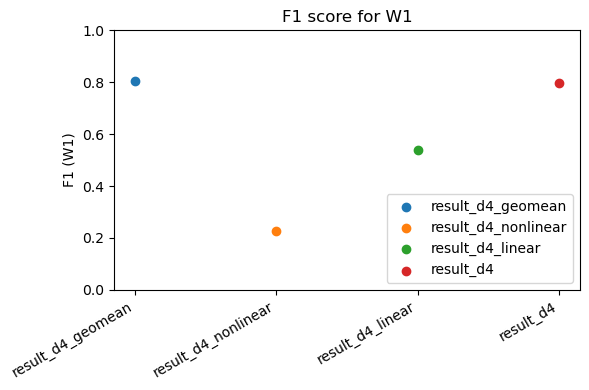

In [20]:
plt.figure(figsize=(6, 4))

for i, name in enumerate(names):
    if "W1" in methods[name]:
        plt.scatter(
            x[i],
            methods[name]["W1"],
            color=colors[name],
            label=name
        )

plt.xticks(x, names, rotation=30, ha="right")
plt.ylim(0, 1)
plt.ylabel("F1 (W1)")
plt.title("F1 score for W1")

plt.legend()
plt.tight_layout()
plt.show()



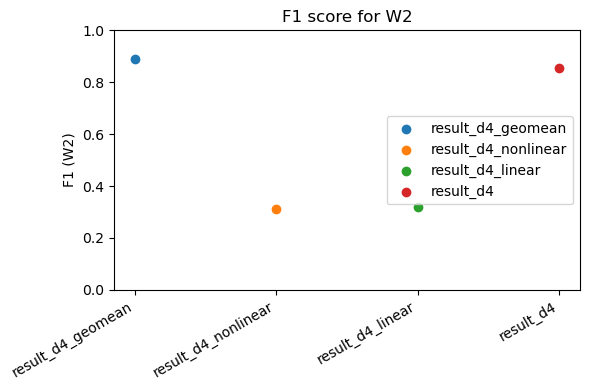

In [21]:
plt.figure(figsize=(6, 4))

for i, name in enumerate(names):
    if "W2" in methods[name]:
        plt.scatter(
            x[i],
            methods[name]["W2"],
            color=colors[name],
            label=name
        )

plt.xticks(x, names, rotation=30, ha="right")
plt.ylim(0, 1)
plt.ylabel("F1 (W2)")
plt.title("F1 score for W2")

plt.legend()
plt.tight_layout()
plt.show()

